# Cross-Validation in Machine Learning

This notebook demonstrates various cross-validation techniques used in machine learning to evaluate model performance and prevent overfitting.

## Table of Contents
1. [Introduction to Cross-Validation](#introduction)
2. [Sample Data Preparation](#data)
3. [K-Fold Cross-Validation](#kfold)
4. [Stratified K-Fold Cross-Validation](#stratified)
5. [Leave-One-Out Cross-Validation (LOOCV)](#loocv)
6. [Time Series Split](#timeseries)
7. [Cross-Validation Scores Comparison](#comparison)
8. [Visualizing Cross-Validation](#visualization)
9. [Best Practices](#bestpractices)

## 1. Introduction to Cross-Validation <a id='introduction'></a>

**Cross-validation** is a resampling procedure used to evaluate machine learning models on a limited data sample. The procedure has a single parameter called `k` that refers to the number of groups that a given data sample is to be split into.

### Why Cross-Validation?
- **Reduces overfitting**: Helps ensure the model generalizes well to unseen data
- **Maximizes data usage**: Uses all data for both training and validation
- **Provides robust estimates**: Gives a better estimate of model performance than a single train-test split

### Common Cross-Validation Methods:
- **K-Fold CV**: Dataset is divided into k subsets (folds)
- **Stratified K-Fold CV**: Ensures each fold has the same proportion of classes
- **Leave-One-Out CV (LOOCV)**: Each sample is used once as test set
- **Time Series Split**: For temporal data, maintains chronological order

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, load_iris, load_wine
from sklearn.model_selection import (
    KFold, StratifiedKFold, LeaveOneOut, 
    TimeSeriesSplit, cross_val_score, cross_validate
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Sample Data Preparation <a id='data'></a>

We'll use multiple datasets to demonstrate cross-validation:
1. **Iris Dataset**: Classic multiclass classification problem
2. **Wine Dataset**: Another multiclass classification problem
3. **Synthetic Dataset**: Custom-generated data for specific demonstrations

Iris Dataset:
  Samples: 150
  Features: 4
  Classes: [0 1 2]
  Class distribution: [50 50 50]

Wine Dataset:
  Samples: 178
  Features: 13
  Classes: [0 1 2]
  Class distribution: [59 71 48]

Synthetic Dataset (Imbalanced):
  Samples: 1000
  Features: 20
  Classes: [0 1 2]
  Class distribution: [596 300 104]


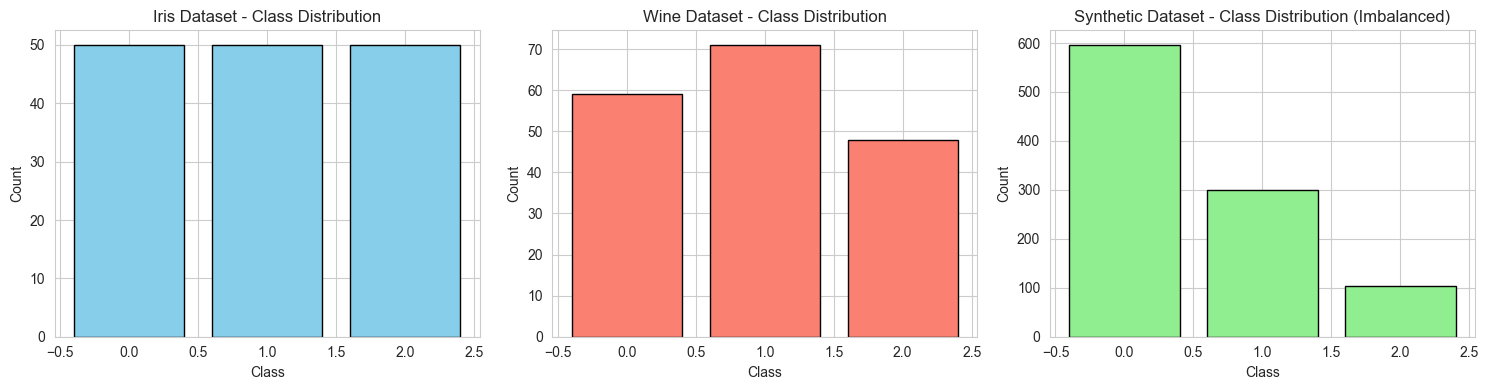

In [2]:
# Load Iris dataset
iris = load_iris()
X_iris, y_iris = iris.data, iris.target

print("Iris Dataset:")
print(f"  Samples: {X_iris.shape[0]}")
print(f"  Features: {X_iris.shape[1]}")
print(f"  Classes: {np.unique(y_iris)}")
print(f"  Class distribution: {np.bincount(y_iris)}")
print()

# Load Wine dataset
wine = load_wine()
X_wine, y_wine = wine.data, wine.target

print("Wine Dataset:")
print(f"  Samples: {X_wine.shape[0]}")
print(f"  Features: {X_wine.shape[1]}")
print(f"  Classes: {np.unique(y_wine)}")
print(f"  Class distribution: {np.bincount(y_wine)}")
print()

# Create synthetic dataset with imbalanced classes
X_synthetic, y_synthetic = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_classes=3,
    weights=[0.6, 0.3, 0.1],  # Imbalanced classes
    random_state=42
)

print("Synthetic Dataset (Imbalanced):")
print(f"  Samples: {X_synthetic.shape[0]}")
print(f"  Features: {X_synthetic.shape[1]}")
print(f"  Classes: {np.unique(y_synthetic)}")
print(f"  Class distribution: {np.bincount(y_synthetic)}")

# Visualize class distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].bar(np.unique(y_iris), np.bincount(y_iris), color='skyblue', edgecolor='black')
axes[0].set_title('Iris Dataset - Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

axes[1].bar(np.unique(y_wine), np.bincount(y_wine), color='salmon', edgecolor='black')
axes[1].set_title('Wine Dataset - Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

axes[2].bar(np.unique(y_synthetic), np.bincount(y_synthetic), color='lightgreen', edgecolor='black')
axes[2].set_title('Synthetic Dataset - Class Distribution (Imbalanced)')
axes[2].set_xlabel('Class')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

## 3. K-Fold Cross-Validation <a id='kfold'></a>

**K-Fold CV** divides the dataset into k equally sized folds. The model is trained k times, each time using k-1 folds for training and 1 fold for validation.

### How it works:
1. Split data into k folds
2. For each fold:
   - Use that fold as the test set
   - Use remaining k-1 folds as training set
   - Train model and evaluate
3. Average the k results to get overall performance estimate

K-Fold Cross-Validation Results (k=5):
Scores for each fold: [1.         1.         0.93333333 0.96666667 0.96666667]
Mean accuracy: 0.9733
Standard deviation: 0.0249
95% Confidence interval: 0.9733 (+/- 0.0489)


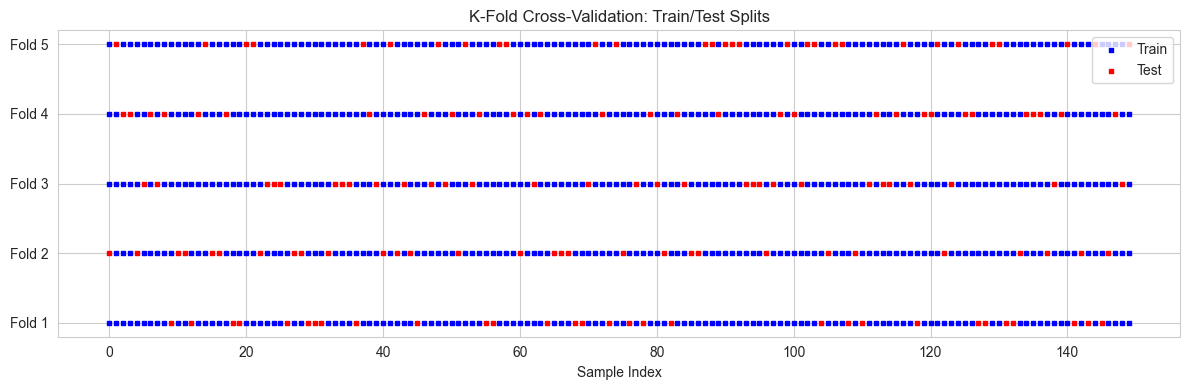

In [3]:
# Create a simple model
model = LogisticRegression(max_iter=1000, random_state=42)

# Perform 5-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Calculate cross-validation scores
cv_scores = cross_val_score(model, X_iris, y_iris, cv=kfold, scoring='accuracy')

print("K-Fold Cross-Validation Results (k=5):")
print("="*50)
print(f"Scores for each fold: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean():.4f}")
print(f"Standard deviation: {cv_scores.std():.4f}")
print(f"95% Confidence interval: {cv_scores.mean():.4f} (+/- {1.96 * cv_scores.std():.4f})")

# Visualize the fold splits
fig, ax = plt.subplots(figsize=(12, 4))

for i, (train_idx, test_idx) in enumerate(kfold.split(X_iris)):
    # Create arrays to visualize
    indices = np.arange(len(X_iris))
    mask = np.zeros(len(X_iris))
    mask[test_idx] = 1
    
    ax.scatter(indices[mask == 0], [i] * len(indices[mask == 0]), 
               c='blue', marker='s', s=10, label='Train' if i == 0 else '')
    ax.scatter(indices[mask == 1], [i] * len(indices[mask == 1]), 
               c='red', marker='s', s=10, label='Test' if i == 0 else '')

ax.set_yticks(range(5))
ax.set_yticklabels([f'Fold {i+1}' for i in range(5)])
ax.set_xlabel('Sample Index')
ax.set_title('K-Fold Cross-Validation: Train/Test Splits')
ax.legend()
plt.tight_layout()
plt.show()

## 4. Stratified K-Fold Cross-Validation <a id='stratified'></a>

**Stratified K-Fold CV** ensures that each fold has approximately the same percentage of samples of each target class as the complete dataset. This is especially important for:
- Imbalanced datasets
- Classification problems
- When you want to ensure each fold is representative of the whole

In [5]:
# Compare K-Fold vs Stratified K-Fold on imbalanced data
print("Comparison on Imbalanced Synthetic Dataset")
print("="*60)
print(f"Overall class distribution: {np.bincount(y_synthetic)}")
print(f"Proportions: {np.bincount(y_synthetic) / len(y_synthetic)}")
print()

# Regular K-Fold
print("Regular K-Fold (may not preserve class proportions):")
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
for i, (train_idx, test_idx) in enumerate(kfold.split(X_synthetic)):
    test_class_dist = np.bincount(y_synthetic[test_idx])
    print(f"  Fold {i+1} test set class distribution: {test_class_dist} "
          f"(proportions: {test_class_dist / len(test_idx):.3f})")

print()

# Stratified K-Fold
print("Stratified K-Fold (preserves class proportions):")
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (train_idx, test_idx) in enumerate(stratified_kfold.split(X_synthetic, y_synthetic)):
    test_class_dist = np.bincount(y_synthetic[test_idx])
    print(f"  Fold {i+1} test set class distribution: {test_class_dist} "
          f"(proportions: {test_class_dist / len(test_idx):.3f})")

# Compare performance
model = RandomForestClassifier(n_estimators=100, random_state=42)

cv_scores_regular = cross_val_score(model, X_synthetic, y_synthetic, 
                                    cv=KFold(n_splits=5, shuffle=True, random_state=42), 
                                    scoring='accuracy')

cv_scores_stratified = cross_val_score(model, X_synthetic, y_synthetic, 
                                       cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                                       scoring='accuracy')

print()
print("Performance Comparison:")
print(f"  Regular K-Fold - Mean: {cv_scores_regular.mean():.4f}, Std: {cv_scores_regular.std():.4f}")
print(f"  Stratified K-Fold - Mean: {cv_scores_stratified.mean():.4f}, Std: {cv_scores_stratified.std():.4f}")

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(5)
width = 0.35

ax.bar(x_pos - width/2, cv_scores_regular, width, label='Regular K-Fold', alpha=0.8)
ax.bar(x_pos + width/2, cv_scores_stratified, width, label='Stratified K-Fold', alpha=0.8)

ax.axhline(y=cv_scores_regular.mean(), color='blue', linestyle='--', alpha=0.5, label='Regular Mean')
ax.axhline(y=cv_scores_stratified.mean(), color='orange', linestyle='--', alpha=0.5, label='Stratified Mean')

ax.set_xlabel('Fold')
ax.set_ylabel('Accuracy')
ax.set_title('K-Fold vs Stratified K-Fold Performance Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'Fold {i+1}' for i in range(5)])
ax.legend()
plt.tight_layout()
plt.show()

Comparison on Imbalanced Synthetic Dataset
Overall class distribution: [596 300 104]
Proportions: [0.596 0.3   0.104]

Regular K-Fold (may not preserve class proportions):


TypeError: unsupported format string passed to numpy.ndarray.__format__

## 5. Leave-One-Out Cross-Validation (LOOCV) <a id='loocv'></a>

**LOOCV** is an extreme case of K-Fold where k equals the number of samples. Each sample is used once as a single-item test set.

### Advantages:
- Maximum use of training data (n-1 samples for training)
- Deterministic (no randomness in split)
- Good for very small datasets

### Disadvantages:
- Computationally expensive (n iterations)
- High variance in performance estimate
- Not suitable for large datasets

In [ ]:
# Note: LOOCV can be slow, so we'll use a small subset
# Use only first 50 samples of iris dataset
X_small = X_iris[:50]
y_small = y_iris[:50]

print(f"Running LOOCV on {len(X_small)} samples...")
print("This means the model will be trained {0} times!".format(len(X_small)))
print()

# Create Leave-One-Out cross-validator
loo = LeaveOneOut()

# Simple model for demonstration
model = LogisticRegression(max_iter=1000, random_state=42)

# Perform LOOCV
cv_scores_loo = cross_val_score(model, X_small, y_small, cv=loo, scoring='accuracy')

print("Leave-One-Out Cross-Validation Results:")
print("="*50)
print(f"Number of iterations: {len(cv_scores_loo)}")
print(f"Accuracy: {cv_scores_loo.mean():.4f}")
print(f"Number of correct predictions: {cv_scores_loo.sum():.0f} / {len(cv_scores_loo)}")
print()

# Compare with 5-fold CV on same data
cv_scores_5fold = cross_val_score(model, X_small, y_small, 
                                  cv=KFold(n_splits=5, shuffle=True, random_state=42), 
                                  scoring='accuracy')

print("Comparison with 5-Fold CV on same data:")
print(f"  LOOCV - Mean: {cv_scores_loo.mean():.4f}, Std: {cv_scores_loo.std():.4f}")
print(f"  5-Fold - Mean: {cv_scores_5fold.mean():.4f}, Std: {cv_scores_5fold.std():.4f}")

# Visualize individual predictions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# LOOCV results
colors = ['green' if score == 1 else 'red' for score in cv_scores_loo]
ax1.bar(range(len(cv_scores_loo)), cv_scores_loo, color=colors, alpha=0.7)
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Correct Prediction (1=Yes, 0=No)')
ax1.set_title(f'LOOCV: Individual Sample Predictions\nAccuracy: {cv_scores_loo.mean():.2%}')
ax1.set_ylim([-0.1, 1.1])

# Comparison boxplot
ax2.boxplot([cv_scores_5fold, cv_scores_loo], 
            labels=['5-Fold CV', 'LOOCV'],
            patch_artist=True)
ax2.set_ylabel('Accuracy')
ax2.set_title('Distribution of Cross-Validation Scores')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Time Series Split <a id='timeseries'></a>

**Time Series Split** is designed for temporal data where the order matters. It respects the temporal order and ensures that:
- Training data always comes before test data
- No future information leaks into the training set

This is crucial for time series forecasting, stock prediction, and other temporal problems.

In [ ]:
# Create synthetic time series data
n_samples = 200
time = np.arange(n_samples)

# Generate trend + seasonality + noise
trend = 0.05 * time
seasonality = 10 * np.sin(2 * np.pi * time / 50)
noise = np.random.normal(0, 2, n_samples)
y_timeseries = trend + seasonality + noise

# Create features (lagged values)
lag_features = 5
X_timeseries = np.array([y_timeseries[i:i+lag_features] for i in range(n_samples - lag_features)])
y_timeseries = y_timeseries[lag_features:]

# Time Series Split
tscv = TimeSeriesSplit(n_splits=5)

print("Time Series Cross-Validation Splits:")
print("="*60)

# Visualize the splits
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Time series data
ax1.plot(y_timeseries, label='Time Series Data', alpha=0.7)
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.set_title('Sample Time Series Data')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Train/Test splits
for i, (train_idx, test_idx) in enumerate(tscv.split(X_timeseries)):
    print(f"Fold {i+1}:")
    print(f"  Train: indices {train_idx[0]} to {train_idx[-1]} (n={len(train_idx)})")
    print(f"  Test:  indices {test_idx[0]} to {test_idx[-1]} (n={len(test_idx)})")
    print()
    
    # Visualize splits
    indices = np.arange(len(X_timeseries))
    
    ax2.scatter(train_idx, [i] * len(train_idx), c='blue', marker='s', s=10, 
                label='Train' if i == 0 else '')
    ax2.scatter(test_idx, [i] * len(test_idx), c='red', marker='s', s=10, 
                label='Test' if i == 0 else '')

ax2.set_yticks(range(5))
ax2.set_yticklabels([f'Split {i+1}' for i in range(5)])
ax2.set_xlabel('Time Index')
ax2.set_title('Time Series Cross-Validation: Train/Test Splits\n(Note: Training set grows, test set moves forward)')
ax2.legend()

plt.tight_layout()
plt.show()

# Perform cross-validation with a simple model
from sklearn.linear_model import Ridge

model = Ridge(alpha=1.0)
cv_scores_ts = cross_val_score(model, X_timeseries, y_timeseries, 
                               cv=tscv, scoring='neg_mean_squared_error')

print("Time Series CV Performance (Ridge Regression):")
print(f"  Mean Squared Error: {-cv_scores_ts.mean():.4f} (+/- {cv_scores_ts.std():.4f})")
print(f"  Scores: {-cv_scores_ts}")

## 7. Cross-Validation Scores Comparison <a id='comparison'></a>

Let's compare multiple models using cross-validation to select the best one.

In [ ]:
# Define multiple models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42)
}

# Use stratified k-fold
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results
results = {}
mean_scores = {}
std_scores = {}

print("Model Comparison using 5-Fold Cross-Validation on Wine Dataset")
print("="*70)

for name, model in models.items():
    # Create pipeline with scaling (important for SVM and Logistic Regression)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    
    # Perform cross-validation with multiple metrics
    cv_results = cross_validate(
        pipeline, X_wine, y_wine, cv=cv_strategy,
        scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
        return_train_score=True
    )
    
    results[name] = cv_results
    mean_scores[name] = cv_results['test_accuracy'].mean()
    std_scores[name] = cv_results['test_accuracy'].std()
    
    print(f"\n{name}:")
    print(f"  Accuracy:  {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std():.4f})")
    print(f"  Precision: {cv_results['test_precision_macro'].mean():.4f} (+/- {cv_results['test_precision_macro'].std():.4f})")
    print(f"  Recall:    {cv_results['test_recall_macro'].mean():.4f} (+/- {cv_results['test_recall_macro'].std():.4f})")
    print(f"  F1-Score:  {cv_results['test_f1_macro'].mean():.4f} (+/- {cv_results['test_f1_macro'].std():.4f})")
    print(f"  Train Acc: {cv_results['train_accuracy'].mean():.4f} (+/- {cv_results['train_accuracy'].std():.4f})")
    
    # Check for overfitting
    overfit = cv_results['train_accuracy'].mean() - cv_results['test_accuracy'].mean()
    if overfit > 0.1:
        print(f"  ⚠️  Potential overfitting detected (gap: {overfit:.4f})")

# Find best model
best_model = max(mean_scores, key=mean_scores.get)
print(f"\n{'='*70}")
print(f"Best Model: {best_model} with accuracy {mean_scores[best_model]:.4f}")

In [ ]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Accuracy comparison
model_names = list(models.keys())
accuracies = [results[name]['test_accuracy'] for name in model_names]

axes[0, 0].boxplot(accuracies, labels=model_names)
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Model Accuracy Comparison (5-Fold CV)')
axes[0, 0].grid(axis='y', alpha=0.3)
plt.setp(axes[0, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 2: Mean scores with error bars
x_pos = np.arange(len(model_names))
means = [mean_scores[name] for name in model_names]
stds = [std_scores[name] for name in model_names]

axes[0, 1].bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(model_names, rotation=45, ha='right')
axes[0, 1].set_ylabel('Mean Accuracy')
axes[0, 1].set_title('Mean Accuracy with Standard Deviation')
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Train vs Test accuracy (overfitting check)
train_means = [results[name]['train_accuracy'].mean() for name in model_names]
test_means = [results[name]['test_accuracy'].mean() for name in model_names]

x_pos = np.arange(len(model_names))
width = 0.35

axes[1, 0].bar(x_pos - width/2, train_means, width, label='Train', alpha=0.8)
axes[1, 0].bar(x_pos + width/2, test_means, width, label='Test', alpha=0.8)
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(model_names, rotation=45, ha='right')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Train vs Test Accuracy (Overfitting Check)')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Multiple metrics comparison for best model
metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
best_results = results[best_model]
metric_scores = [best_results[f'test_{metric}'].mean() for metric in metrics]

axes[1, 1].bar(metric_names, metric_scores, alpha=0.7, color='green', edgecolor='black')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title(f'Multiple Metrics for Best Model: {best_model}')
axes[1, 1].set_ylim([0, 1.1])
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(metric_scores):
    axes[1, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 8. Visualizing Cross-Validation <a id='visualization'></a>

Let's create comprehensive visualizations to understand how cross-validation affects model evaluation.

In [ ]:
# Compare different k values for k-fold CV
k_values = [2, 3, 5, 10, 15, 20]
model = RandomForestClassifier(n_estimators=100, random_state=42)

mean_accuracies = []
std_accuracies = []
cv_times = []

print("Effect of Different K Values on Cross-Validation")
print("="*60)

import time

for k in k_values:
    start_time = time.time()
    
    cv_strategy = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_wine, y_wine, cv=cv_strategy, scoring='accuracy')
    
    elapsed_time = time.time() - start_time
    
    mean_accuracies.append(scores.mean())
    std_accuracies.append(scores.std())
    cv_times.append(elapsed_time)
    
    print(f"k={k:2d}: Mean={scores.mean():.4f}, Std={scores.std():.4f}, Time={elapsed_time:.2f}s")

# Visualize the effect of k
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Mean accuracy vs k
axes[0].plot(k_values, mean_accuracies, marker='o', linewidth=2, markersize=8)
axes[0].fill_between(k_values, 
                      np.array(mean_accuracies) - np.array(std_accuracies),
                      np.array(mean_accuracies) + np.array(std_accuracies),
                      alpha=0.3)
axes[0].set_xlabel('Number of Folds (k)')
axes[0].set_ylabel('Mean Accuracy')
axes[0].set_title('Mean Accuracy vs Number of Folds')
axes[0].grid(alpha=0.3)

# Plot 2: Standard deviation vs k
axes[1].plot(k_values, std_accuracies, marker='s', color='orange', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Folds (k)')
axes[1].set_ylabel('Standard Deviation')
axes[1].set_title('Variance in Estimates vs Number of Folds')
axes[1].grid(alpha=0.3)

# Plot 3: Computation time vs k
axes[2].plot(k_values, cv_times, marker='^', color='green', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Folds (k)')
axes[2].set_ylabel('Computation Time (seconds)')
axes[2].set_title('Computational Cost vs Number of Folds')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Best Practices <a id='bestpractices'></a>

### Key Takeaways:

1. **Choose the Right CV Method:**
   - **K-Fold (k=5 or k=10)**: Default choice for most problems
   - **Stratified K-Fold**: Use for classification, especially with imbalanced data
   - **LOOCV**: Only for very small datasets (< 100 samples)
   - **Time Series Split**: Mandatory for temporal data

2. **Typical K Values:**
   - k=5: Good balance between bias and variance
   - k=10: More reliable but more computationally expensive
   - k=n (LOOCV): Maximum bias reduction, but high variance and cost

3. **Common Pitfalls:**
   - ❌ Using regular K-Fold for imbalanced data → Use Stratified K-Fold
   - ❌ Using K-Fold for time series → Use Time Series Split
   - ❌ Data leakage: Scaling/preprocessing before splitting → Use pipelines
   - ❌ Testing on the same data used for hyperparameter tuning → Use nested CV

4. **Performance Metrics:**
   - Always report mean AND standard deviation
   - Use multiple metrics (accuracy, precision, recall, F1)
   - Check for overfitting (compare train vs. test scores)

5. **Computational Considerations:**
   - Larger k = more computation but better estimates
   - Consider parallel processing for large datasets
   - Balance between accuracy of estimate and computational cost

In [ ]:
# Example: Proper pipeline to avoid data leakage
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

print("Best Practice Example: Using Pipeline to Prevent Data Leakage")
print("="*70)

# ❌ WRONG WAY - Data leakage
print("\n❌ INCORRECT: Scaling before CV (causes data leakage):")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_wine)  # Fitting on entire dataset!
model = SVC(random_state=42)
scores_wrong = cross_val_score(model, X_scaled, y_wine, cv=5)
print(f"   Mean accuracy: {scores_wrong.mean():.4f} (INFLATED DUE TO LEAKAGE!)")

# ✅ CORRECT WAY - Use pipeline
print("\n✅ CORRECT: Using pipeline (no data leakage):")
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling happens within each fold
    ('pca', PCA(n_components=10)),
    ('classifier', SVC(random_state=42))
])
scores_correct = cross_val_score(pipeline, X_wine, y_wine, cv=5)
print(f"   Mean accuracy: {scores_correct.mean():.4f} (CORRECT ESTIMATE)")

print(f"\n⚠️  Difference: {(scores_wrong.mean() - scores_correct.mean()):.4f}")
print("   This shows how data leakage can give overly optimistic results!")

# Nested CV example for hyperparameter tuning
print("\n" + "="*70)
print("Nested Cross-Validation for Hyperparameter Tuning")
print("="*70)

from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': ['scale', 'auto'],
}

# Inner CV for hyperparameter tuning
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
clf = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring='accuracy')

# Outer CV for performance estimation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
nested_scores = cross_val_score(clf, X_wine, y_wine, cv=outer_cv)

print(f"\nNested CV Results:")
print(f"  Mean accuracy: {nested_scores.mean():.4f} (+/- {nested_scores.std():.4f})")
print(f"  Individual fold scores: {nested_scores}")
print(f"\n  This is an UNBIASED estimate of model performance with optimized hyperparameters.")

## Summary

In this notebook, we covered:

✅ **What is cross-validation** and why it's important  
✅ **K-Fold CV**: The standard approach for most problems  
✅ **Stratified K-Fold CV**: Essential for imbalanced classification  
✅ **Leave-One-Out CV**: For small datasets only  
✅ **Time Series Split**: For temporal data  
✅ **Model comparison** using cross-validation  
✅ **Visualizations** to understand CV behavior  
✅ **Best practices** to avoid common pitfalls  

### Next Steps:
- Try cross-validation on your own datasets
- Experiment with different k values
- Implement nested CV for hyperparameter tuning
- Explore other CV strategies (ShuffleSplit, GroupKFold, etc.)

Happy learning! 🚀